# Wikipedia Data Exploration

Starting with the query of the Wikipedia API using ```pywikibot``` to get the links for the articles on ```horses```, which we then mapped to their resolved IDs using the mappings from Wikidata.

```Pywikibot``` is a Python library and collection of tools that automate work on MediaWiki sites. Originally designed for Wikipedia, it is now used throughout the Wikimedia Foundation's projects and on many other MediaWiki wikis.

### Task:
1. Explore data that on Mediawiki links,
2. Document the usage of an API to retrieve wiki data. 
3. Details what: trying to identify some interesting links (users & pages they edited, pages & page references, pages &topics, etc).

4. formulate one interesting research question in the beginning (e.g., Are most editors of wiki pages making frequent contributions to a broad range of topics on the platform or are they primarily occasional contributors with a narrow topic focus?) 3) demonstrate how your analysis attempts to address the question.

5. begin with some basic exploratory analysis of the data relevant for answering your research questions. E.g., look at some of the page revisions history and count various things like number of unique editors, number of edits within a one week period, one month period, size of edits and so on.

6. Generate some plots (bar charts, histograms, violin plots etc.) to illustrate the exploratory analysis you did 

7. Once you have identified an interesting link to explore, then construct a network from the data and generate a visualization of the network. 

8. It would also be nice to have some statistics computed on the network structure (e.g., degree distribution). 

9. The task is intentionally design with the freedom to explore what you think is relevant and interesting. focus on being creative and scientific with how you approach the data.

Links:
- https://www.mediawiki.org/wiki/API:Main_page
- https://www.mediawiki.org/wiki/API:Revisions



### Defining the Research Question
The most edited content on horses

In [1]:
import pywikibot
from pywikibot import pagegenerators as pg
import numpy as np 
import pandas as pd

In [2]:
def list_template_usage(site_obj, tmpl_name):
    """
    
    :param site_obj: site object (pywikibot.Site())
    :param tmpl_name: template name (String)
    :return: a generator object
      
    It creates a list of all
    pages using that template and returns them as a generator.
    The generator will load 50 pages at a time for iteration.
    """
    
    name = "{}:{}".format(site_obj.namespace(10), tmpl_name)
    tmpl_page = pywikibot.Page(site_obj, name)
    ref_gen = pg.ReferringPageGenerator(tmpl_page, onlyTemplateInclusion=True)
    filter_gen = pg.NamespaceFilterPageGenerator(ref_gen, namespaces=[0])
    gen = site_obj.preloadpages(filter_gen, pageprops=True)
    return gen

In [3]:
site = pywikibot.Site("en", 'wikipedia')
tmpl_gen = list_template_usage(site, "Infobox horse")
l_temp = []
for page in tmpl_gen:
    item = pywikibot.ItemPage.fromPage(page)
    temp = [page.title(), item.getID(), item.contributors(), item.editTime()]
    l_temp.append(temp)

Retrieving 50 pages from wikipedia:en.
Retrieving 50 pages from wikipedia:en.
Retrieving 50 pages from wikipedia:en.
Retrieving 50 pages from wikipedia:en.
Retrieving 50 pages from wikipedia:en.
Retrieving 31 pages from wikipedia:en.


In [36]:
df = pd.DataFrame(l_temp, columns = ["breed", "page_ID", "contributor_nr", "last revision"])

# Change the last revision to datetime column
df['last revision'] = pd.to_datetime(df['last revision'], format="%Y-%b-%d")

# # Retrieve total edits much faster and cleaner way
df['total_edits'] = df["contributor_nr"].apply(lambda x: sum(x.values()))

# sort in descending order by total_edits
df.sort_values(by=['total_edits'], axis=0, ascending = False, inplace=True)

# reset the indexes of data
df = df.reset_index(drop=True)

df.head()

,breed,page_ID,contributor_nr,last revision,total_edits
0,Thoroughbred,Q210826,"{'Máté': 1, 'KrBot': 3, 'MatSuBot': 2, 'Simon ...",2018-12-08 17:56:48,116
1,Mustang,Q211848,"{'189.202.74.129': 1, 'KrBot': 3, 'MatSuBot': ...",2018-11-14 20:48:33,85
2,Arabian horse,Q184138,"{'جار الله': 1, 'Russian Rocky': 1, 'KrBot': 2...",2018-12-19 22:52:54,81
3,Akhal-Teke,Q472753,"{'Russian Rocky': 1, 'KrBot': 3, 'Czeva': 1, '...",2018-12-16 09:00:29,62
4,Andalusian horse,Q489798,"{'KrBot': 4, 'MatSuBot': 3, 'Ma3r': 1, 'Magnus...",2018-11-02 23:19:31,60


In [37]:
df.info()

# Make sure no column values are missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 5 columns):
breed             281 non-null object
page_ID           281 non-null object
contributor_nr    281 non-null object
last revision     281 non-null datetime64[ns]
total_edits       281 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 11.1+ KB


In [38]:
df.shape

(281, 5)

## list of all & unique contributors


In [39]:
contributors = []
for l in df["contributor_nr"]:
    contributors.extend(l)

print("All Contributors: ", len(contributors))
unique_contributors = list(set(contributors))
# unique_contributors = pd.DataFrame(unique_contributors, columns=['User'])
# print("Unique Contributors: ",len(unique_contributors))

All Contributors:  4723


In [8]:
# ## Unique Contributors DataFrame

# unique_contributors = pd.DataFrame(contributors, columns=['User'])
# unique_contributors = unique_contributors.drop_duplicates().reset_index(drop=True)
# print(len(unique_contributors))
# unique_contributors

## Total Edits by each user

In [40]:
# initially, give a default value of count for each user
contributor_edits_mapping = {user:0 for user in unique_contributors}

for row in df["contributor_nr"]:
    for user in row:
        contributor_edits_mapping[user] += int(row[user])
        
#contributor_edits_mapping["KrBot"] - dictionary

In [41]:
# As a Dataframe
c_e_map_df = pd.DataFrame(list(contributor_edits_mapping.items()), columns=["User", "Edits"], index=range(len(contributor_edits_mapping)))
c_e_map_df.sort_values(by=['Edits'], axis=0, inplace=True, ascending = False)
c_e_map_df = c_e_map_df.reset_index(drop=True)
c_e_map_df.head()


,User,Edits
0,KrBot,586
1,Dexbot,434
2,Tsaag Valren,412
3,Legobot,408
4,GerardM,284


## Contributor, Breeds & Edits mapping

In [42]:
# initially, give a default value of count for each user
contributor_breed_edits_mapping = {user:dict() for user in unique_contributors}

for index, row in df.iterrows():  
    for user in row["contributor_nr"]:
        contributor_breed_edits_mapping[user].update({row["breed"] : row["contributor_nr"][user]})
        
# contributor_breed_edits_mapping["KrBot"]

In [12]:
Top10Users = c_e_map_df.head(10)
Top10Users

,User,Edits
0,KrBot,586
1,Dexbot,434
2,Tsaag Valren,412
3,Legobot,408
4,GerardM,284
5,Shinnin,255
6,PLbot,180
7,MatSuBot,172
8,ThieolBot,162
9,BotNinja,148


In [43]:
Top10Sum = df.head(10)
Top10Sum

,breed,page_ID,contributor_nr,last revision,total_edits
0,Thoroughbred,Q210826,"{'Máté': 1, 'KrBot': 3, 'MatSuBot': 2, 'Simon ...",2018-12-08 17:56:48,116
1,Mustang,Q211848,"{'189.202.74.129': 1, 'KrBot': 3, 'MatSuBot': ...",2018-11-14 20:48:33,85
2,Arabian horse,Q184138,"{'جار الله': 1, 'Russian Rocky': 1, 'KrBot': 2...",2018-12-19 22:52:54,81
3,Akhal-Teke,Q472753,"{'Russian Rocky': 1, 'KrBot': 3, 'Czeva': 1, '...",2018-12-16 09:00:29,62
4,Andalusian horse,Q489798,"{'KrBot': 4, 'MatSuBot': 3, 'Ma3r': 1, 'Magnus...",2018-11-02 23:19:31,60
5,Lipizzan,Q217671,"{'KrBot': 4, 'MatSuBot': 2, 'Andreevart': 1, '...",2018-11-02 23:19:02,58
6,American Quarter Horse,Q466602,"{'KrBot': 3, 'DenesFeri': 1, 'Adventurous36': ...",2018-11-02 23:19:27,56
7,Shetland pony,Q214720,"{'Karoke Cirno': 1, 'KrBot': 2, 'JhealdBatch':...",2018-11-25 09:27:25,54
8,Icelandic horse,Q262924,"{'KrBot': 3, 'AmaryllisGardener': 2, 'JhealdBa...",2018-11-02 23:19:08,54
9,Criollo horse,Q1140113,"{'KrBot': 2, 'Adventurous36': 12, 'MatSuBot': ...",2018-11-02 23:21:05,53


In [44]:
Least10Sum = df.tail(10)
Least10Sum

,breed,page_ID,contributor_nr,last revision,total_edits
271,Angevin horse,Q2849573,"{'Pi bot': 1, 'Nono314': 2, 'Dexbot': 2, 'Frie...",2018-05-05 22:44:17,7
272,Karacabey horse,Q3192903,"{'KrBot': 2, 'Shinnin': 1, 'Dexbot': 1, 'Gerar...",2018-11-02 23:22:59,6
273,Unmol,Q3551917,"{'KrBot': 2, 'Shinnin': 1, 'Justlettersandnumb...",2018-11-02 23:23:22,6
274,Friesian cross,Q5504459,"{'KrBot': 2, 'Shinnin': 1, 'GerardM': 1, 'Sk!d...",2018-11-02 23:23:50,5
275,North American Single-footing Horse,Q22286429,"{'Ammarpad': 1, 'MatSuBot': 1, 'Mateo K 01': 1...",2018-11-14 06:17:08,5
276,Ventasso horse,Q2962956,"{'KrBot': 2, 'Shinnin': 1, 'GerardM': 1, 'Sk!d...",2018-11-02 23:22:42,5
277,Colonial Spanish horse,Q2962917,"{'BD2412': 1, 'MatSuBot': 1, 'Tuanminh01': 1, ...",2018-11-24 17:24:00,4
278,Mountain Pleasure Horse,Q22286238,"{'KrBot': 2, 'Bamyers99': 1, 'GZWDer (flood)': 1}",2018-11-02 23:25:06,4
279,Dongola horse,Q3036272,"{'Tsaag Valren': 1, 'Sk!dbot': 1}",2018-07-12 08:37:38,2
280,Burmese Horse,Q28231458,{'MechQuester': 1},2017-01-13 03:13:27,1


## Plotting

In [45]:
from matplotlib import pyplot as plt

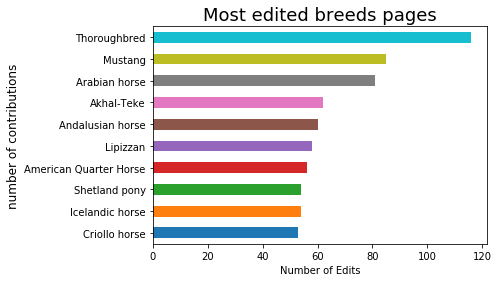

In [46]:
%matplotlib inline 
plt.figure()
ax = Top10Sum.groupby('breed')['total_edits'].median().sort_values().plot(kind='barh')

ax.set_xlabel("Number of Edits")

# Change the y axis label to Arial
ax.set_ylabel("number of contributions", fontname="DejaVu Sans", fontsize=12)

# Set the title 
ax.set_title("Most edited breeds pages", fontname='DejaVu Sans', fontsize=18)

plt.show()

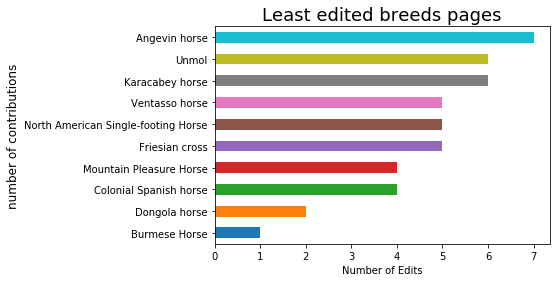

In [47]:
%matplotlib inline 
plt.figure()
axa = Least10Sum.groupby('breed')['total_edits'].median().sort_values().plot(kind='barh')
axa.set_xlabel("Number of Edits")

# Change the y axis label to Arial
axa.set_ylabel("number of contributions", fontname="DejaVu Sans", fontsize=12)

# Set the title 
axa.set_title("Least edited breeds pages", fontname="DejaVu Sans", fontsize=18)

plt.show()

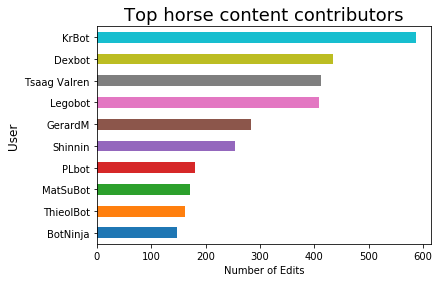

In [21]:
%matplotlib inline 
plt.figure()

xo = Top10Users.groupby('User')['Edits'].median().sort_values().plot(kind='barh')
xo.set_xlabel("Number of Edits")

# Change the y axis label to Arial
xo.set_ylabel("User", fontname="DejaVu Sans", fontsize=12)

# Set the title 
xo.set_title("Top horse content contributors", fontname="DejaVu Sans", fontsize=18)

plt.show()

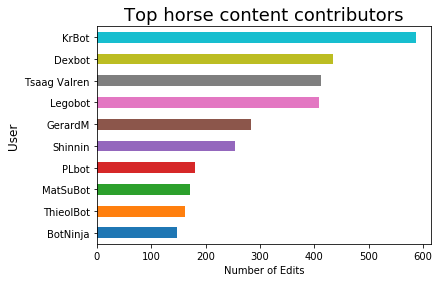

In [48]:
xo = Top10Users.groupby('User')['Edits'].median().sort_values().plot(kind='barh')
xo.set_xlabel("Number of Edits")

# Change the y axis label to Arial
xo.set_ylabel("User", fontname="DejaVu Sans", fontsize=12)

# Set the title 
xo.set_title("Top horse content contributors", fontname="DejaVu Sans", fontsize=18)

plt.show()

# Contribuors range
- Contributed Edits for less than equal to 50
- Contributed Edits between 50 to 300
- Contributed Edits for more than 300 times.

In [49]:
print(len(c_e_map_df))
print(len(c_e_map_df.loc[c_e_map_df['Edits']<=50]))

# Low(0) : <=50, Med(1): 50 < edits <=300, High(2): > 300
c_e_map_df.loc[c_e_map_df['Edits'] <=50, 'Category'] = 'Low'
c_e_map_df.loc[(c_e_map_df['Edits'] > 50) & (c_e_map_df['Edits'] <= 300), 'Category'] = 'Med'
c_e_map_df.loc[c_e_map_df['Edits'] > 300, 'Category'] = 'High'
c_e_map_df.head()

675
648


,User,Edits,Category
0,KrBot,586,High
1,Dexbot,434,High
2,Tsaag Valren,412,High
3,Legobot,408,High
4,GerardM,284,Med


In [50]:
# Count of each category
c_e_map_df.groupby(['Category']).count()

,User,Edits
Category,,
High,4,4
Low,648,648
Med,23,23


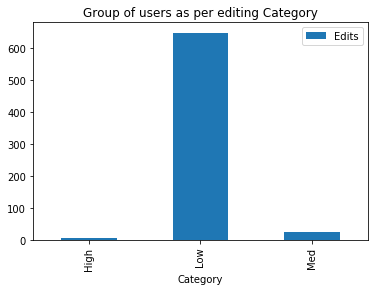

In [51]:
c_e_map_df[['Edits', 'Category']].groupby(['Category']).count().plot(kind="bar", title="Group of users as per editing Category")

## Explore any user details
- Let's say user='KrBot
- made over 500 edits
- what breeds
- on what days he edited : can't say as last revision date could be change by any user
- what is information about him available


In [52]:
def get_top_breeds_of_user(user='KrBot', top_count=5):
    top_breeds = sorted(contributor_breed_edits_mapping[user].items(), key=lambda kv: kv[1])
    return top_breeds[:top_count]

def user_details(user='KrBot'):
    total_edits = c_e_map_df.loc[c_e_map_df['User'] == user, 'Edits'].iloc[0]
    print("Total Number of Edits by '{user}' is {edits}".format(user=user, edits = total_edits))
    # top 5 breeds of user
    top_breeds = get_top_breeds_of_user(user='KrBot', top_count=5)
    print("Top breeds of '{user}' are {edits} ".format(user=user, edits=top_breeds))

In [53]:
user_details(user='KrBot')

Total Number of Edits by 'KrBot' is 586
Top breeds of 'KrBot' are [('Bidet horse', 1), ('Arabian horse', 2), ('Shetland pony', 2), ('Criollo horse', 2), ('Percheron', 2)] 


In [54]:
user_details(user='Shinnin')

Total Number of Edits by 'Shinnin' is 255
Top breeds of 'Shinnin' are [('Bidet horse', 1), ('Arabian horse', 2), ('Shetland pony', 2), ('Criollo horse', 2), ('Percheron', 2)] 


## Which page has got the most edits

In [55]:
page_id = df.head(1)['page_ID'].iloc[0]
page_id

'Q210826'

## Which page has got the least edits

In [56]:
page_id = df.tail(1)['page_ID'].iloc[0]
page_id

'Q28231458'

## Which breed has got the most edits

In [57]:
breed = df.head(1)['breed'].iloc[0]
breed

'Thoroughbred'

## Which page has got the least edits

In [58]:
breed = df.tail(1)['breed'].iloc[0]
breed

'Burmese Horse'

In [67]:
list(contributor_breed_edits_mapping[user].keys())[:10]

['Thoroughbred',
 'Mustang',
 'Arabian horse',
 'Akhal-Teke',
 'Andalusian horse',
 'Lipizzan',
 'American Quarter Horse',
 'Shetland pony',
 'Icelandic horse',
 'Criollo horse']

## Networking

  if cb.is_numlike(alpha):



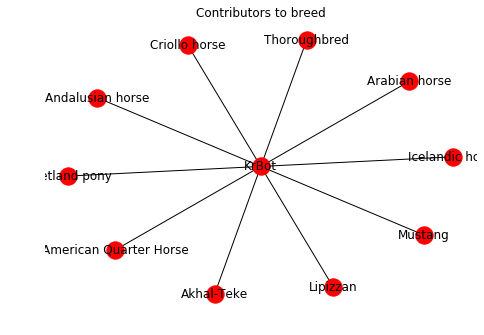

In [77]:
import networkx as nx

# Build a dataframe with 4 connections
user="KrBot"
to = list(contributor_breed_edits_mapping[user].keys())[:10]
df_2 = pd.DataFrame.from_dict({'from':user, 'to':to})

 
# Build your graph
G=nx.from_pandas_edgelist(df_2, 'from', 'to')
 
# Plot it
nx.draw(G, with_labels=True)
plt.title("Contributors to breed")
plt.show()
